In [2]:
import torch
import numpy as np
from auction import *
import torch.nn as nn
import torch.nn.functional as F
import timeit
import sinkhorn
import matplotlib.pyplot as plt

In [3]:
# plot parameters
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": [
         "\\usepackage{units}",          # load additional packages
         "\\usepackage{metalogo}",
         "\\usepackage{unicode-math}",   # unicode math setup
         r"\setmathfont{xits-math.otf}",
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
         ]
})

In [4]:
lambrange = np.concatenate((np.linspace(0.0005, 1, 20), np.geomspace(0.0005, 1, 20)))
lambrange = np.sort(lambrange[1:-1]) # different values of lambda to plot
niter_sink = 1000 # require a large niter_sink for small values of lamb
niter = 1000
lr = 0.01
batch = 1000
size_layer = 100
K = 10
nactions = 2+K
y = torch.linspace(1./K, 1., K) # discretization of uniform distribution
beta= torch.ones(K)/K
nexp = 10
err_threshold = 1e-3
device = "cpu"
startexp = 1

In [12]:
utility = []
privacy_losses = []
losses = []
for lamb in lambrange:
    us = 0
    ps = 0
    s = 0
    for exp in range(startexp, nexp+startexp):
        us+=np.load('experiments/sinkhorn_auction/{0}_lamb{1}_k{2}_sinkiter{3}_lr{4}_sinkhorn_{5}_batch{6}/eval_utility_loss.npy'.format(exp,lamb,y.size(0), 
                  niter_sink, lr, device, batch))
        ps+=np.load('experiments/sinkhorn_auction/{0}_lamb{1}_k{2}_sinkiter{3}_lr{4}_sinkhorn_{5}_batch{6}/eval_privacy_loss.npy'.format(exp,lamb,y.size(0), 
                  niter_sink, lr, device, batch))
        s+=np.load('experiments/sinkhorn_auction/{0}_lamb{1}_k{2}_sinkiter{3}_lr{4}_sinkhorn_{5}_batch{6}/eval_loss.npy'.format(exp,lamb,y.size(0), 
                  niter_sink, lr, device, batch))
    utility.append(1-us/nexp)
    privacy_losses.append(ps/nexp)
    losses.append(s/nexp)

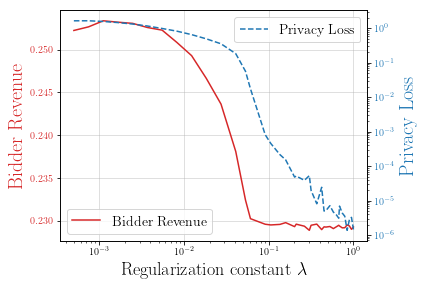

In [50]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Regularization constant $\lambda$', fontsize=18)
ax1.set_xscale('log')
ax1.set_ylabel('Bidder Revenue', color=color, fontsize=20)
ax1.plot(lambrange, utility, '-', color=color, label='Bidder Revenue')
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim(0, 0.3)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Privacy Loss', color=color, fontsize=20)  # we already handled the x-label with ax1
ax2.plot(lambrange, privacy_losses, '--', color=color, label='Privacy Loss')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid(alpha=0.5)
ax2.legend(fontsize=14)
ax1.legend(loc='lower left', fontsize=14)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('figures/tradeoff_K{}.pgf'.format(K))
plt.show()

In [14]:
exp=1
lamb = 0.001
y = torch.linspace(1./K, 1., K)
beta= torch.ones(K)/K

In [15]:
net = torch.load('experiments/sinkhorn_auction/{0}_lamb{1}_k{2}_sinkiter{3}_lr{4}_sinkhorn_{5}_batch{6}/network'.format(exp,lamb,y.size(0), 
                  niter_sink, lr, device, batch))

In [16]:
_, gamma, _, _, _ = eval(net, y, beta, lamb=lamb, niter_sink=(int)(1e5), size_batch=(int)(1e6))

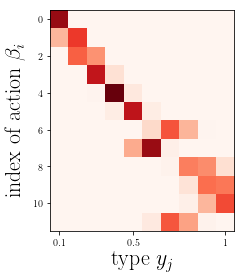

In [17]:
plt.imshow(gamma.detach().numpy(), cmap=plt.cm.Reds, interpolation='none')
plt.ylabel(r'index of action $\beta_i$', fontsize=22)
plt.xlabel(r'type $y_j$', fontsize=22)
x_positions = [0, 4, 9] # pixel count at label position
x_labels = [(x+1)/K for x in x_positions]
x_labels[-1] = (int)(x_labels[-1])
plt.xticks(x_positions, x_labels)
plt.tight_layout()
plt.show()

In [18]:
gamma = gamma.detach().numpy()
gamma_ordered = np.copy(gamma)
gamma_ordered[7, :] = gamma[6,:]
gamma_ordered[6, :] = gamma[7,:]
gamma_ordered[8, :] = gamma[-1, :]
for i in range(9, 12):
    gamma_ordered[i,:] = gamma[i-1, :]

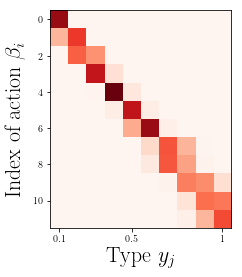

In [19]:
plt.imshow(gamma_ordered, cmap=plt.cm.Reds, interpolation='none')
plt.ylabel(r'Index of action $\beta_i$', fontsize=22)
plt.xlabel(r'Type $y_j$', fontsize=22)
x_positions = [0, 4, 9] # pixel count at label position
x_labels = [(x+1)/K for x in x_positions]
x_labels[-1] = (int)(x_labels[-1])
plt.xticks(x_positions, x_labels)
plt.savefig('figures/gamma_heatmap_lamb0001.pgf'.format(lamb))
plt.show()

# Evolution of the beta functions

In [20]:
lamb3 = 0.001
net3 = torch.load('experiments/sinkhorn_auction/{0}_lamb{1}_k{2}_sinkiter{3}_lr{4}_sinkhorn_{5}_batch{6}/network'.format(exp,lamb3,y.size(0), 
                  niter_sink, lr, device, batch))
_, gamma3, _, _, _ = eval(net3, y, beta, lamb=lamb3, niter_sink=(int)(1e4), size_batch=(int)(1e5))

In [21]:
lamb2 = 0.1
net2 = torch.load('experiments/sinkhorn_auction/{0}_lamb{1}_k{2}_sinkiter{3}_lr{4}_sinkhorn_{5}_batch{6}/network'.format(exp,lamb2,y.size(0), 
                  niter_sink, lr, device, batch))
_, gamma2, _, _, _ = eval(net2, y, beta, lamb=lamb2, niter_sink=(int)(1e4), size_batch=(int)(1e5))

## Compute non private strategies

In [22]:
class NoPrivateBidder(nn.Module):
    def __init__(self, size_layer = 100, nactions=12, device="cpu", val=1):
        super().__init__()
        self.size_layer = size_layer
        self.nactions = nactions

        self.fc1 =nn.Linear(1, self.size_layer)
        torch.nn.init.uniform_(self.fc1.bias,a=-1.0, b=1.0)
        torch.nn.init.uniform_(self.fc1.weight,a=-1.0, b=2.0)

        self.fc2 = nn.Linear(self.size_layer, 1)
        torch.nn.init.normal_(self.fc2.weight,mean=2*val/self.size_layer, std = 0.01*val)
        torch.nn.init.normal_(self.fc2.bias,mean=0.0, std = 0.001*val)

    def forward(self, inp):
        return(self.fc2(F.relu(self.fc1(inp))))

In [23]:
def noprivateloss(net, input, y, size_batch=1000, eta=1000, rp=0):
    ###### Compute loss matrix ###
    out = net(input)
    true_val = y*input
    grad = torch.autograd.grad(torch.sum(out),input,retain_graph=True, create_graph=True)[0]
    virtual = out - grad
    indicator = torch.sigmoid(eta*(virtual-rp))
    winning = torch.min(out, torch.ones(out.size())) # uniform on [0,1] adversary
    l = (true_val - virtual)*winning*indicator
    return 1 - 1/size_batch*torch.sum(l)

In [24]:
def noprivate_train(net, y, learning_rate=0.01, max_iter=1000, size_batch=1000):
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0)

    distrib = torch.distributions.Exponential(torch.tensor(1.))

    iterations = 0
    loss_profile = []
    while iterations<max_iter:
        optimizer.param_groups[-1]['lr']*=0.99

        input = torch.zeros((size_batch, 1), requires_grad=True)
        samples = distrib.sample((size_batch, 1))
        input.data = samples.clone()

        ###### Compute loss matrix ###
       
        loss =  noprivateloss(net, input, y, size_batch=size_batch)

        loss.backward()
        optimizer.step()

        loss_profile.append(loss.cpu().detach().numpy())

        optimizer.zero_grad()
        iterations += 1
    return loss_profile

In [25]:
y_space = [0, 4, 9]

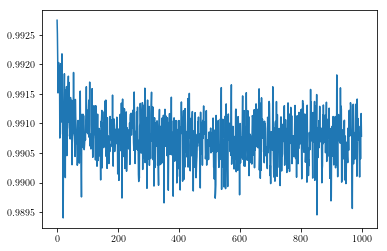

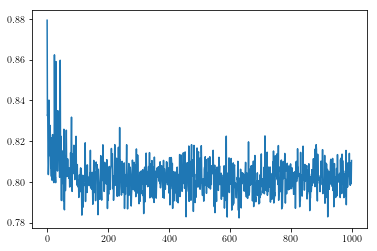

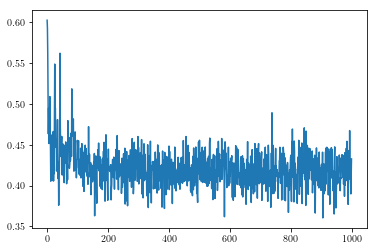

In [26]:
nets = {}
for i in y_space:
    net1 = NoPrivateBidder(val=y[i])
    loss_profile = noprivate_train(net1, y[i], learning_rate=lr, max_iter=niter, size_batch=batch)
    nets[i] = net1
    plt.figure()
    plt.plot(loss_profile)
    plt.show()

## Final plot

([<matplotlib.axis.XTick at 0x7f8e12fd9710>,
 <a list of 3 Text xticklabel objects>)

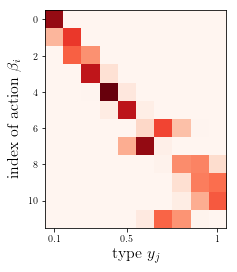

In [27]:
plt.imshow(gamma3.detach().numpy(), cmap=plt.cm.Reds, interpolation='none')
plt.ylabel(r'index of action $\beta_i$', fontsize=16)
plt.xlabel(r'type $y_j$', fontsize=16)
x_positions = [0, 4, 9] # pixel count at label position
x_labels = [(x+1)/K for x in x_positions]
x_labels[-1] = (int)(x_labels[-1])
plt.xticks(x_positions, x_labels)

([<matplotlib.axis.XTick at 0x7f8e12ea14a8>,
 <a list of 3 Text xticklabel objects>)

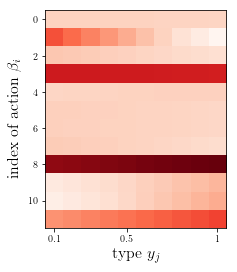

In [28]:
plt.imshow(gamma2.detach().numpy(), cmap=plt.cm.Reds, interpolation='none')
plt.ylabel(r'index of action $\beta_i$', fontsize=16)
plt.xlabel(r'type $y_j$', fontsize=16)
x_positions = [0, 4, 9] # pixel count at label position
x_labels = [(x+1)/K for x in x_positions]
x_labels[-1] = (int)(x_labels[-1])
plt.xticks(x_positions, x_labels)

In [29]:
torch.argmax(gamma3, dim=0)

tensor([ 0,  1,  3,  4,  5,  7,  6,  8,  9, 10])

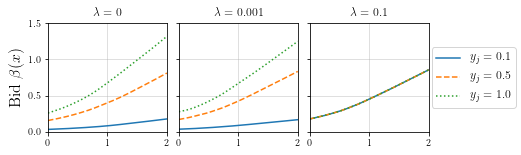

In [37]:
x = np.linspace(0, 2, 1000)
x_t = torch.linspace(0, 2, 1000)

# plot parameters
xl = (0, 2)
yl=(0, 1.5)
alpha = 0.5

fig = plt.figure()
ls = ['-', '--', ':']
plt.subplot(131)
for n, i in enumerate(y_space):
    output = nets[i](x_t.view(-1, 1))
    plt.plot(x, output.detach().numpy(), ls[n], label='y_j = {}'.format(y[i]))
plt.xlim(xl)
plt.ylim(yl)
plt.ylabel(r'Bid $\beta(x)$', fontsize=16)
#plt.xlabel(r'$x$')
plt.title(r'$\lambda=0$', fontsize=12)
plt.grid(alpha=alpha)

l = []
################
_, output = net3(x_t.view(-1, 1))
plt.subplot(132)
for n, i in enumerate(y_space):
    lz, = plt.plot(x, output[torch.argmax(gamma3, dim=0)[i]].detach().numpy(), ls[n], label='y_j = {}'.format(y[i]))
    l.append(lz)
plt.xlim(xl)
plt.ylim(yl)
#plt.xlabel(r'$x$')
plt.tick_params(axis='y', labelleft=False)
plt.title(r'$\lambda={}$'.format(lamb3), fontsize=12)
plt.grid(alpha=alpha)

##################
_, output = net2(x_t.view(-1, 1))
plt.subplot(133)
for n, i in enumerate(y_space):
    plt.plot(x, output[torch.argmax(gamma2, dim=0)[i]].detach().numpy(), ls[n], label='y_j = {}'.format(y[i]))
plt.xlim(xl)
plt.ylim(yl)
#plt.xlabel(r'$x$')
plt.tick_params(axis='y', labelleft=False)
plt.title(r'$\lambda={}$'.format(lamb2), fontsize=12)
plt.grid(alpha=alpha)

labels = ['$y_j={:.1f}$'.format(y[i]) for i in y_space]

plt.subplots_adjust(left=0.125, right=0.83, wspace=0.1, hspace=0) # decrease space between subplots
fig.set_figheight(2)
fig.set_figwidth(7.5)
# bbox_to_anchor=(1.14, 0.56)
fig.legend(l, labels, 'right', fontsize=12)
plt.savefig('figures/beta_evolution.pgf'.format(lamb))
plt.show()